In [2]:
from Functions0 import *
#from Functions import *
import pandas as pd

gr_DATA = pd.read_pickle("greenland_clean.pkl") 
gr = Graph(gr_DATA)
#gr.draw_bbox()

r=1
jakobs = [-49.5-r, -49.5+r, 69.10-r, 69.10+r]
helheim = [-38.12-r,-38.12+r, 66.21-r,66.21+r,]
kanger = [-33-r,-33+r, 68.38-r,68.38+r]


#gr_helheim = Graph(gr_DATA,bbox=helheim,label='helheim')
#gr_helheim.draw_bbox()


/Users/noahbergam/Desktop/GAGA/Functions0.py:37: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries = gpd.read_file( gpd.datasets.get_path("naturalearth_lowres"))


(2332, 2)


/Users/noahbergam/Desktop/GAGA/Functions0.py:113: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries = gpd.read_file( gpd.datasets.get_path("naturalearth_lowres"))


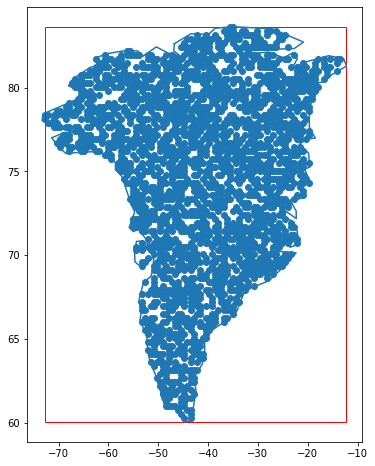

In [3]:
resolution = 100 # on the order of 1000 by 1000 grid (though many of those points are lost)
time_step = 0.5 # every year

# gives list of [x,y] pairs of where we take "synthetic measurements" 
# grid_pts[i] -> [x,y]
raw_grid_pts = gr.get_grid(resolution)
# for now we are just doing random downsampling
grid_pts = gr.grid_reduce(raw_grid_pts)
#grid_pts= raw_grid_pts

gr.draw_bbox(grid_pts)

In [5]:
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    
    # Earth's radius in km
    R = 6371.0
    
    # Calculate the distance in km
    distance = R * c
    
    return distance

def triangle_area_on_earth(lat1, lon1, lat2, lon2, lat3, lon3):
    # Calculate the sides of the triangle (great-circle distances)
    side_a = haversine(lat1, lon1, lat2, lon2)
    side_b = haversine(lat2, lon2, lat3, lon3)
    side_c = haversine(lat3, lon3, lat1, lon1)
    
    # Calculate the semi-perimeter
    s = (side_a + side_b + side_c) / 2
    
    # Heron's formula to calculate the area of the triangle
    area = math.sqrt(s * (s - side_a) * (s - side_b) * (s - side_c))
    
    return area


# important helper function for later
def triangle_area(vertices):
    a, b, c = vertices
    return triangle_area_on_earth(a[1], a[0], b[1], b[0], c[1], c[0])
    #return 0.5 * np.abs((b[0] - a[0]) * (c[1] - a[1]) - (c[0] - a[0]) * (b[1] - a[1]))

# get the zoning from a Delunay triangulation!
tri = Delaunay(grid_pts)
triangle_indices = tri.simplices
# get the triangle centers and areas!
triangle_centers = np.mean(grid_pts[triangle_indices], axis=1)
triangle_areas =  np.array([triangle_area(grid_pts[triangle_indices][i]) for i in range(len(grid_pts[triangle_indices]))])

ixs = greenland_filter_ixs(triangle_centers)
triangle_centers = triangle_centers[ixs]
triangle_areas = triangle_areas[ixs]

#gr.draw_bbox(triangle_centers)

/Users/noahbergam/Desktop/GAGA/Functions0.py:44: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries = gpd.read_file( gpd.datasets.get_path("naturalearth_lowres"))


2

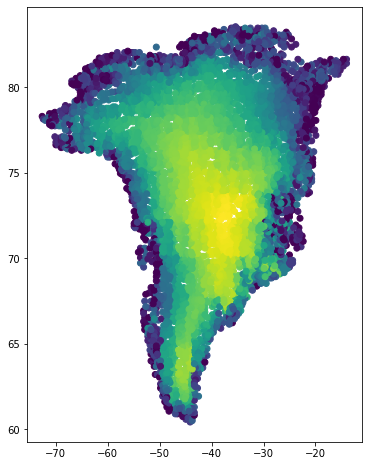

In [7]:
# creates a time series over the given time step at each grid point
# discrete_grid_ts[i] -> [h0,h1,...,hn]
discrete_grid_ts, time_points = gr.make_grid_ts(triangle_centers, time_step)
# meters into kilometers
discrete_grid_ts = np.array(discrete_grid_ts)
discrete_grid_ts = discrete_grid_ts / 1000


fig,ax = plt.subplots(figsize=(6,8))
plt.scatter( triangle_centers[:,0] , triangle_centers[:,1] , c = discrete_grid_ts[:,0])
#discrete_grid_ts[:,1]

In [ ]:
# run an ALPS interpolation on each of the time series. Return the error in hte 
# ALPS_dh_dt[i] -> [dh0/dt, dh1/dt, ..., dhn/dt ]
# ALPS_error[i] -> [sig_{h0}, sig_{h1}, ..., sig_{hn}]
ALPS_dh_dt, ALPS_error, preds = alps_dhdt(discrete_grid_ts, time_points)

# since the grid time series is in kilometers and the points are in half years, 
# then 2*dh/dt should be in years


/Users/noahbergam/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


In [ ]:
# plot of the total change 

ALPS_dh_dt = np.array(ALPS_dh_dt)
ALPS_error = np.array(ALPS_error)


total_change = []
for i in range(len(time_points)):
    total_change.append( sum( ALPS_dh_dt[:,i] * triangle_areas) )


total_error = []
for i in range(len(time_points)):
    total_error.append( np.sqrt( sum( ALPS_error[:,i]**2 * triangle_areas) ) )
    
total_change = np.array(total_change)
total_error = np.array(total_error)

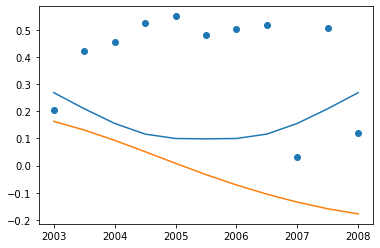

In [ ]:
plt.plot(time_points, ALPS_error[0,:])
plt.plot(time_points,  ALPS_dh_dt[0,:]) 
plt.scatter(time_points, discrete_grid_ts[0,:])

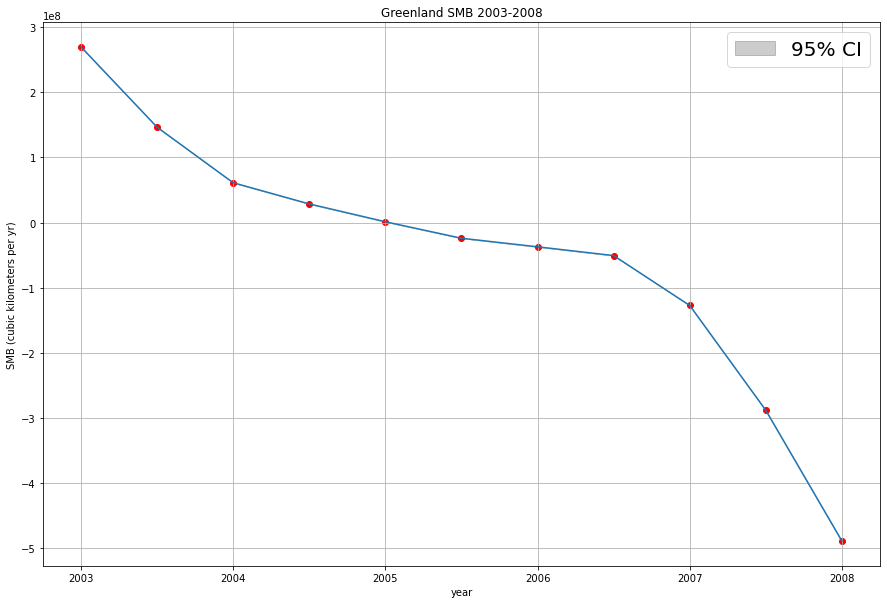

In [ ]:
# ATTEMPTED VOLUME CHANGE ESTIMATE

f1 = figure(figsize=(15,10))
ax = subplot2grid((1,1),(0,0))
#ax2 = ax.twinx()
#ax2.set_ylabel('change in ')

ax.set_xlabel('year')
ax.set_ylabel('SMB (cubic kilometers per yr)')
ax.set_title('Greenland SMB 2003-2008')
ax.plot(time_points, total_change)
ax.scatter(time_points, total_change, c='r')
err = 2*np.array(total_error)
ax.fill_between(time_points,total_change- err,total_change +err, alpha = 0.2,color = 'k',label = '95% CI')
ax.legend(fontsize=20)
ax.grid(True)


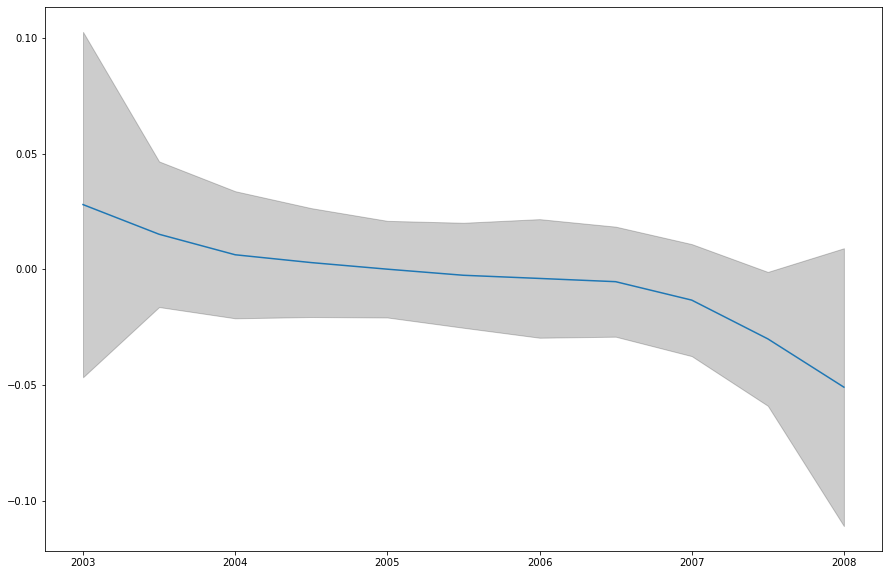

In [ ]:
# ATTEMPTED AVERAGE HEIGHT CHANGE ESTIMATE
f1 = figure(figsize=(15,10))
ax = subplot2grid((1,1),(0,0))

avg_dh_dt = np.array([ sum(ALPS_dh_dt[:,i])/ALPS_dh_dt.shape[0] for i in range(ALPS_dh_dt.shape[1])])
avg_height_error = np.array([ sum(ALPS_error[:,i])/ALPS_error.shape[0] for i in range(ALPS_error.shape[1])])

ax.plot(time_points, avg_dh_dt)
ax.fill_between(time_points,avg_dh_dt- .2*avg_height_error,avg_dh_dt + .2*avg_height_error, alpha = 0.2,color = 'k',label = '95% CI')


In [ ]:
print(ALPS_dh_dt.shape, ALPS_error.shape)

(4507, 11, 1) (4507, 11)


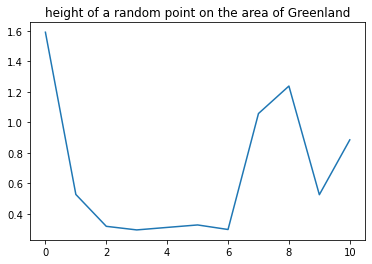

In [ ]:
plt.title('height of a random point on the area of Greenland')
plt.plot(discrete_grid_ts[12,:])

In [ ]:
print('Predicted size of the Greenland Ice Sheet:', int(sum(triangle_areas)))
print('Predicted size is 2.1 million km^3')
print('Actual size is 1.7 million km^3')

Predicted size of the Greenland Ice Sheet: 2131231
Predicted size is 2.1 million km^3
Actual size is 1.7 million km^3
